In [ ]:
#%pip install geopandas rasterio fiona shapely
#! pip install GDAL
#from osgeo import gdal

In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
from PIL import Image
import glob
import random
from tifffile import imread  

**Part 1: Extracting images and region from lakes_regions.gpkg and lake_polygons_training.gpkg**

In [2]:
import os

train_dir = "train"
test_dir = "test"
mask_dir = "mask"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)


In [5]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

# Ensure output directories exist
output_dirs = ["train", "test", "mask"]
for dir_name in output_dirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# Load the region polygons
regions_gdf = gpd.read_file("lakes_regions.gpkg")

# Load the training lake polygons
training_gdf = gpd.read_file("lake_polygons_training.gpkg")

# Define the training and testing mapping
training_mapping = {
    'Greenland26X_22W_Sentinel2_2019-06-03_05.tif': [2, 4, 6],
    'Greenland26X_22W_Sentinel2_2019-06-19_20.tif': [1, 3, 5],
    'Greenland26X_22W_Sentinel2_2019-07-31_25.tif': [2, 4, 6],
    'Greenland26X_22W_Sentinel2_2019-08-25_29.tif': [1, 3, 5]
}

testing_mapping = {
    'Greenland26X_22W_Sentinel2_2019-06-03_05.tif': [1, 3, 5],
    'Greenland26X_22W_Sentinel2_2019-06-19_20.tif': [2, 4, 6],
    'Greenland26X_22W_Sentinel2_2019-07-31_25.tif': [1, 3, 5],
    'Greenland26X_22W_Sentinel2_2019-08-25_29.tif': [2, 4, 6]
}

def create_mask(lake_gdf, shape, out_transform):
    mask_array = np.zeros(shape, dtype=np.uint8)
    for _, row in lake_gdf.iterrows():
        individual_mask = rasterio.features.geometry_mask([row.geometry], transform=out_transform, invert=True, out_shape=shape)
        mask_array = np.logical_or(mask_array, individual_mask).astype(np.uint8)
    return mask_array

def extract_and_save_region(image_path):
    with rasterio.open(image_path) as src:
        if src.crs != regions_gdf.crs:
            raise ValueError(f"CRS mismatch between {image_path} and lakes_regions.gpkg")

        for idx, region_row in regions_gdf.iterrows():
            region_geom = region_row.geometry
            region_num = idx + 1
            out_image, out_transform = mask(src, [mapping(region_geom)], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            base_filename = os.path.basename(image_path)

            if region_num in training_mapping[base_filename]:
                out_name = os.path.join("train", f"{base_filename}_region_{region_num}.tif")
                with rasterio.open(out_name, "w", **out_meta) as dest:
                    dest.write(out_image)

                lake_polygons_filtered = training_gdf[(training_gdf['image'] == base_filename) & (training_gdf['region_num'] == region_num)]
                mask_image = create_mask(lake_polygons_filtered, out_image.shape[1:], out_transform)

                mask_name = os.path.join("mask", f"{base_filename}_mask_region_{region_num}.tif")
                out_meta.update(count=1)
                with rasterio.open(mask_name, "w", **out_meta) as mask_dest:
                    mask_dest.write(mask_image, 1)

            elif region_num in testing_mapping[base_filename]:
                out_name = os.path.join("test", f"{base_filename}_region_{region_num}.tif")
                with rasterio.open(out_name, "w", **out_meta) as dest:
                    dest.write(out_image)

# Process each image in the directory
image_directory = "/home/in18657@ad.umbc.edu/lake/4_tif"
for image_file in os.listdir(image_directory):
    if image_file.endswith(".tif"):
        print(f"Processing {image_file}...")
        extract_and_save_region(os.path.join(image_directory, image_file))
        print(f"Finished processing {image_file}.")

Processing Greenland26X_22W_Sentinel2_2019-06-03_05.tif...
Finished processing Greenland26X_22W_Sentinel2_2019-06-03_05.tif.
Processing Greenland26X_22W_Sentinel2_2019-06-19_20.tif...
Finished processing Greenland26X_22W_Sentinel2_2019-06-19_20.tif.
Processing Greenland26X_22W_Sentinel2_2019-08-25_29.tif...
Finished processing Greenland26X_22W_Sentinel2_2019-08-25_29.tif.
Processing Greenland26X_22W_Sentinel2_2019-07-31_25.tif...
Finished processing Greenland26X_22W_Sentinel2_2019-07-31_25.tif.


**End Part 1**

**Data exploratory analysis, there is no need to run below cells**

In [6]:
import rasterio

with rasterio.open('mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif') as src:
    tile_width, tile_height = src.block_shapes[0]
    print(f"Tile Width: {tile_width}, Tile Height: {tile_height}")


Tile Width: 1, Tile Height: 14957


In [11]:
data=ds.read()
data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [4]:
ds.meta



{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 87040,
 'height': 160000,
 'count': 3,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(38.21851414258808, 0.0, -5684468.919511961,
        0.0, -38.21851414258808, 15654303.392804058)}

In [7]:
ds. shape
# rows and columns
# = height and width

(160000, 87040)

In [9]:
ds. descriptions

(None, None, None)

In [12]:
data.size

41779200000

In [13]:
data.dtype

dtype('uint8')

In [14]:
data.min()

0

In [15]:
data.max()

255

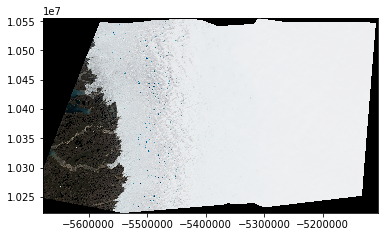

In [3]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

img = rasterio.open('train/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_2.tif')
show(img)

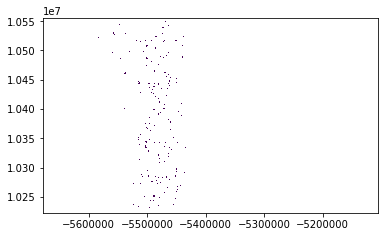

In [1]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

img = rasterio.open('mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif')
show(img)

In [52]:
import rasterio
import numpy as np

def most_frequent_pixel_value(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        
        # Calculate the unique pixel values and their counts
        values, counts = np.unique(data, return_counts=True)
        
        # Return the pixel value with the highest count
        return values[np.argmax(counts)]
raster_path = 'mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif'
background_value = most_frequent_pixel_value(raster_path)
print(f"The most frequent pixel value (likely background) is: {background_value}")


The most frequent pixel value (likely background) is: 0


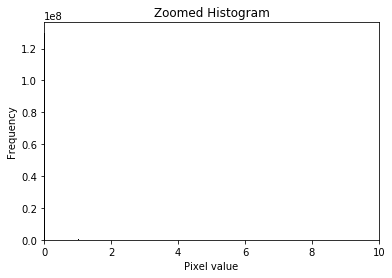

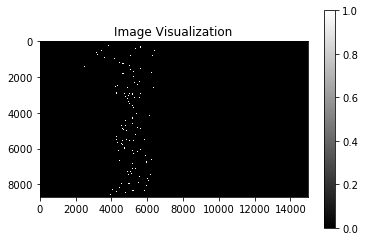

In [58]:

def plot_zoomed_histogram(image_path):
    with rasterio.open(image_path) as src:
        img_data = src.read(1)  

        # Plot histogram
        plt.hist(img_data.ravel(), bins=256, histtype='step', color='black')
        plt.xlim([0, 10])  # Zoom in on the first few pixel values
        plt.title("Zoomed Histogram")
        plt.xlabel("Pixel value")
        plt.ylabel("Frequency")
        plt.show()

def visualize_image(image_path):
    with rasterio.open(image_path) as src:
        img_data = src.read(1)

    plt.imshow(img_data, cmap='gray', vmin=0, vmax=1)  # Set vmin and vmax for binary images
    plt.colorbar()
    plt.title("Image Visualization")
    plt.show()

# Choose a sample image
sample_image = "mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif"
plot_zoomed_histogram(sample_image)
visualize_image(sample_image)



In [59]:

# Compare the percentage of black and white pixels in the mask images.
input_directory = "mask"

def compute_percentages(img_path):
    with rasterio.open(img_path) as src:
        img_data = src.read(1)

    total_pixels = img_data.size
    white_pixels = np.sum(img_data == 1)
    black_pixels = np.sum(img_data == 0)

    white_percentage = (white_pixels / total_pixels) * 100
    black_percentage = (black_pixels / total_pixels) * 100

    return black_percentage, white_percentage

# Iterate through all files in the directory and compute percentages
for filename in os.listdir(input_directory):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory, filename)
        black_perc, white_perc = compute_percentages(full_path)

        print(f"Image: {filename}")
        print(f"Black Percentage: {black_perc:.2f}%")
        print(f"White Percentage: {white_perc:.2f}%")
        print("----------")


Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_2.tif
Black Percentage: 99.18%
White Percentage: 0.82%
----------
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_3.tif
Black Percentage: 99.51%
White Percentage: 0.49%
----------
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif
Black Percentage: 99.73%
White Percentage: 0.27%
----------
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_4.tif
Black Percentage: 99.92%
White Percentage: 0.08%
----------
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_6.tif
Black Percentage: 99.76%
White Percentage: 0.24%
----------
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_1.tif
Black Percentage: 99.22%
White Percentage: 0.78%
----------
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_6.tif
Black Percentage: 99.99%
White Percentage: 0.01%
----------
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_mask_region_5.tif
Black Percentage: 99

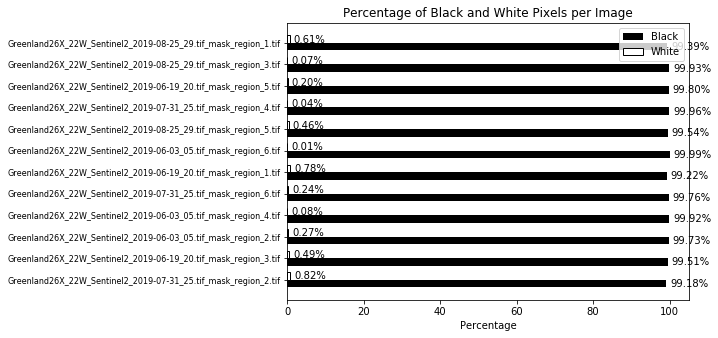

In [62]:

input_directory = "mask"

def compute_percentages(img_path):
    with rasterio.open(img_path) as src:
        img_data = src.read(1)

    total_pixels = img_data.size
    white_pixels = np.sum(img_data == 1)
    black_pixels = np.sum(img_data == 0)

    white_percentage = (white_pixels / total_pixels) * 100
    black_percentage = (black_pixels / total_pixels) * 100

    return black_percentage, white_percentage

# Lists to store data
images = []
black_percentages = []
white_percentages = []

# Iterate through all files in the directory and compute percentages
for filename in os.listdir(input_directory):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory, filename)
        black_perc, white_perc = compute_percentages(full_path)
        
        images.append(filename)
        black_percentages.append(black_perc)
        white_percentages.append(white_perc)

# Plotting
bar_width = 0.35
index = np.arange(len(images))
fig, ax = plt.subplots(figsize=(10, len(images) * 0.4))  

bar1 = ax.barh(index, black_percentages, bar_width, label='Black', color='black')
bar2 = ax.barh(index + bar_width, white_percentages, bar_width, label='White', color='white', edgecolor='black')

# Labeling the bars with their respective percentages
for i, v in enumerate(black_percentages):
    ax.text(v + 1, i, f"{v:.2f}%", color='black', va='center')
for i, v in enumerate(white_percentages):
    ax.text(v + 1, i + bar_width, f"{v:.2f}%", color='black', va='center')

ax.set_xlabel('Percentage')
ax.set_title('Percentage of Black and White Pixels per Image')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(images, rotation=0, fontsize=8)
ax.legend()

plt.tight_layout()
plt.show()


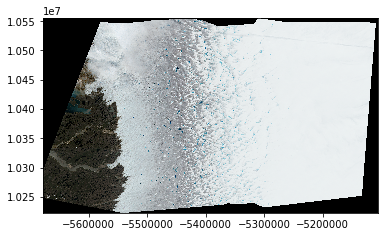

In [18]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

img = rasterio.open('test/Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_2.tif')
show(img)

In [7]:
import geopandas as gpd
## Read the provided .gpkg files to get the regions and training polygon

# Read the GeoPackage files
regions_gdf = gpd.read_file('lakes_regions.gpkg')
training_gdf = gpd.read_file('lake_polygons_training.gpkg')


In [25]:
# check masks
with rasterio.open('mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif') as src:
    num_channels = src.count
    dtype = src.dtypes[0]  # Datatype of the first band

print(f"Number of channels: {num_channels}")
print(f"Datatype: {dtype}")


Number of channels: 1
Datatype: uint8


In [19]:
import numpy as np
import rasterio

with rasterio.open('mask/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif') as src:
    mask_data = src.read(1)  # Reads the first band

unique_values = np.unique(mask_data)
print(unique_values)

if len(unique_values) == 2:
    print("The mask is binary.")
else:
    print("The mask is colorful.")


[0 1]
The mask is binary.


In [26]:
# check images
with rasterio.open('train/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_2.tif') as src:
    num_channels = src.count
    dtype = src.dtypes[0]  # Datatype of the first band

print(f"Number of channels: {num_channels}")
print(f"Datatype: {dtype}")


Number of channels: 3
Datatype: uint8


**Check the size size of extracted train, mask, and test images**

In [63]:
import os
import rasterio

input_directory = "mask"  

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")


Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_mask_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_5.tif, Width: 31216, Height: 24194
Image: Greenla

In [64]:
import os
import rasterio

input_directory = "train"

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")

Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_4.tif, 

In [65]:

input_directory = "test"

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")

Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_region_5.tif,

**Check the number of train images and their masks**

In [28]:
import os

mask_folder = "/home/in18657@ad.umbc.edu/lake/mask"
train_folder = "/home/in18657@ad.umbc.edu/lake/train"

mask_files = [filename for filename in os.listdir(mask_folder) if filename.endswith(".tif")]
train_files = [filename for filename in os.listdir(train_folder) if filename.endswith(".tif")]

num_mask_files = len(mask_files)
num_train_files = len(train_files)

print(f"Number of mask files: {num_mask_files}")
print(f"Number of train files: {num_train_files}")

if num_mask_files == num_train_files:
    print("Number of files in mask and train folders is the same.")
else:
    print("Number of files in mask and train folders is different.")


Number of mask files: 12
Number of train files: 12
Number of files in mask and train folders is the same.


**Check the size of each train image and its corresponding masks.**

In [36]:
import os
import rasterio

mask_folder = "mask"
train_folder = "train"

mask_files = [os.path.join(mask_folder, filename) for filename in os.listdir(mask_folder) if filename.endswith(".tif")]
train_files = [os.path.join(train_folder, filename) for filename in os.listdir(train_folder) if filename.endswith(".tif")]

mask_sizes = []
train_sizes = []

for file in mask_files:
    with rasterio.open(file) as src:
        mask_sizes.append((src.width, src.height))

for file in train_files:
    with rasterio.open(file) as src:
        train_sizes.append((src.width, src.height))

mask_sizes.sort()
train_sizes.sort()

print("Sizes of mask images:")
for size in mask_sizes:
    print(size)

print("Sizes of train images:")
for size in train_sizes:
    print(size)

if mask_sizes == train_sizes:
    print("Sizes of mask and train images are the same.")
else:
    print("Sizes of mask and train images are different.")


Sizes of mask images:
(13078, 8733)
(13078, 8733)
(13524, 10358)
(13524, 10358)
(14414, 9723)
(14414, 9723)
(14957, 8710)
(14957, 8710)
(28235, 22641)
(28235, 22641)
(31216, 24194)
(31216, 24194)
Sizes of train images:
(13078, 8733)
(13078, 8733)
(13524, 10358)
(13524, 10358)
(14414, 9723)
(14414, 9723)
(14957, 8710)
(14957, 8710)
(28235, 22641)
(28235, 22641)
(31216, 24194)
(31216, 24194)
Sizes of mask and train images are the same.


In [30]:
import os

mask_folder = "mask"
train_folder = "train"

mask_files = [os.path.join(mask_folder, filename) for filename in os.listdir(mask_folder) if filename.endswith(".tif")]
train_files = [os.path.join(train_folder, filename) for filename in os.listdir(train_folder) if filename.endswith(".tif")]

mask_sizes = [os.path.getsize(file) for file in mask_files]
train_sizes = [os.path.getsize(file) for file in train_files]

total_mask_size = sum(mask_sizes)
total_train_size = sum(train_sizes)

print(f"Total size of mask images: {total_mask_size} bytes")
print(f"Total size of train images: {total_train_size} bytes")

if total_mask_size == total_train_size:
    print("Size of mask and train images is the same.")
else:
    print("Size of mask and train images is different.")

Total size of mask images: 3839463002 bytes
Total size of train images: 11516542874 bytes
Size of mask and train images is different.


**End of the data exploratory analysis part**

**Part 2: Tile train and mask**

The original extracted regions in the dataset vary in size. To ensure consistency, we tile these regions into 512x512 patches with overlapping sections and zero padding applied as needed. The resulting tiled images are saved in three separate folders:

Trained_tiles: Tiled images used for training. 

Mask_tiles: Tiled masks associated with the training data.

Test_tiles_no_overlap: Tiled test images without overlapping sections.

In [1]:
# tile mask with pad
import os
import numpy as np
import rasterio
from rasterio.windows import Window

def save_tile(src, window, outfile, tile_size):
    """Save a tile from the source raster to the specified output file."""
    kwds = src.profile.copy()
    kwds.update({
        'height': tile_size,
        'width': tile_size,
        'transform': rasterio.windows.transform(window, src.transform)})

    img = src.read(window=window)

    # Zero-padding if the tile is smaller than the desired size
    if img.shape[1] < tile_size or img.shape[2] < tile_size:
        padded_img = np.zeros((img.shape[0], tile_size, tile_size), dtype=img.dtype)
        padded_img[:, :img.shape[1], :img.shape[2]] = img
    else:
        padded_img = img

    with rasterio.open(outfile, 'w', **kwds) as dst:
        dst.write(padded_img)

def tile_raster(input_raster, output_folder, prefix, tile_size=512, overlap=69):
    with rasterio.open(input_raster) as src:
        width, height = src.meta['width'], src.meta['height']

        # Compute the number of tiles in x and y direction
        nx = int(np.ceil(width / (tile_size - overlap)))
        ny = int(np.ceil(height / (tile_size - overlap)))

        # Tile the raster
        for i in range(nx):
            for j in range(ny):
                x_start = i * (tile_size - overlap)
                y_start = j * (tile_size - overlap)

                window = Window(x_start, y_start, tile_size, tile_size)
                outfile = os.path.join(output_folder, f"{prefix}_tile_{i:03d}_{j:03d}.tif")

                save_tile(src, window, outfile, tile_size)

input_directory = "mask"
mask_tiles_dir = "/mask_tiles"

# Ensure output directories exist
for dir_path in [mask_tiles_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Loop through all files in the directory and tile them
for filename in os.listdir(input_directory):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory, filename)
        base_name, _ = os.path.splitext(filename)  # Remove extension

        if "mask" in base_name:
            tile_raster(full_path, mask_tiles_dir, base_name)


In [13]:
import os

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'mask_tiles'
print(count_files_in_directory(directory_path))


19966


In [20]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window

def save_tile(src, window, outfile, tile_size):
    """Save a tile from the source raster to the specified output file."""
    kwds = src.profile.copy()
    kwds.update({
        'height': tile_size,
        'width': tile_size,
        'transform': rasterio.windows.transform(window, src.transform)})

    img = src.read(window=window)

    # Zero-padding if the tile is smaller than the desired size
    if img.shape[1] < tile_size or img.shape[2] < tile_size:
        padded_img = np.zeros((img.shape[0], tile_size, tile_size), dtype=img.dtype)
        padded_img[:, :img.shape[1], :img.shape[2]] = img
    else:
        padded_img = img

    with rasterio.open(outfile, 'w', **kwds) as dst:
        dst.write(padded_img)

def tile_raster(input_raster, output_folder, prefix, tile_size=512, overlap=69):
    with rasterio.open(input_raster) as src:
        width, height = src.meta['width'], src.meta['height']

        # Compute the number of tiles in x and y direction
        nx = int(np.ceil(width / (tile_size - overlap)))
        ny = int(np.ceil(height / (tile_size - overlap)))

        # Tile the raster
        for i in range(nx):
            for j in range(ny):
                x_start = i * (tile_size - overlap)
                y_start = j * (tile_size - overlap)

                window = Window(x_start, y_start, tile_size, tile_size)
                outfile = os.path.join(output_folder, f"{prefix}_tile_{i:03d}_{j:03d}.tif")

                save_tile(src, window, outfile, tile_size)

input_directory = "train"
train_tiles_dir = "train_tile"

# Ensure output directories exist
for dir_path in [train_tiles_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Loop through all files in the directory and tile them
for filename in os.listdir(input_directory):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory, filename)
        base_name, _ = os.path.splitext(filename)  # Remove extension

        
        tile_raster(full_path, train_tiles_dir, base_name)

In [21]:
import os

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'train_tiles'
print(count_files_in_directory(directory_path))


19966


**Tile train and second way**

In [15]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window

def save_tile(src, window, outfile, tile_size):
    """Save a tile from the source raster to the specified output file."""
    kwds = src.profile.copy()
    kwds.update({
        'height': tile_size,
        'width': tile_size,
        'transform': rasterio.windows.transform(window, src.transform)})

    img = src.read(window=window)

    # Zero-padding if the tile is smaller than the desired size
    if img.shape[1] < tile_size or img.shape[2] < tile_size:
        padded_img = np.zeros((img.shape[0], tile_size, tile_size), dtype=img.dtype)
        padded_img[:, :img.shape[1], :img.shape[2]] = img
    else:
        padded_img = img

    with rasterio.open(outfile, 'w', **kwds) as dst:
        dst.write(padded_img)

def tile_raster(input_raster, output_folder, prefix, tile_size=512, overlap=69):
    with rasterio.open(input_raster) as src:
        width, height = src.meta['width'], src.meta['height']

        # Compute the number of tiles in x and y direction
        nx = int(np.ceil(width / (tile_size - overlap)))
        ny = int(np.ceil(height / (tile_size - overlap)))

        # Tile the raster
        for i in range(nx):
            for j in range(ny):
                x_start = i * (tile_size - overlap)
                y_start = j * (tile_size - overlap)

                window = Window(x_start, y_start, tile_size, tile_size)
                outfile = os.path.join(output_folder, f"{prefix}_tile_{i:03d}_{j:03d}.tif")

                save_tile(src, window, outfile, tile_size)

# Define input and output directories
input_directory_mask = "/home/in18657@ad.umbc.edu/lake/mask"
input_directory_train = "/home/in18657@ad.umbc.edu/lake/train"
mask_tiles_dir = "/home/in18657@ad.umbc.edu/lake/mask_tiles"
train_tiles_dir = "/home/in18657@ad.umbc.edu/lake/train_tiles"

# Ensure output directories exist
for dir_path in [mask_tiles_dir, train_tiles_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Tile mask images
for filename in os.listdir(input_directory_mask):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory_mask, filename)
        base_name, _ = os.path.splitext(filename)  # Remove extension

        tile_raster(full_path, mask_tiles_dir, base_name)

# Tile train images
for filename in os.listdir(input_directory_train):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory_train, filename)
        base_name, _ = os.path.splitext(filename)  # Remove extension

        tile_raster(full_path, train_tiles_dir, base_name)


**End of the part 3**

**Sanity checks, there is no need to run below cells**

In [23]:
# Sanity check

def print_non_512x512_files(folder_path):
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".tif"):  # Adjust the file extension as needed
                file_path = os.path.join(root, file_name)
                with rasterio.open(file_path) as src:
                    width = src.width
                    height = src.height
                    if width != 512 or height != 512:
                        print(f"File: {file_name} is {width}x{height} pixels and not 512x512.")

# Specify the folder path containing the tiled files
folder_path = "test_tiles"

# Call the function to print non-512x512 files
print_non_512x512_files(folder_path)


In [24]:
import os

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'mask_tiles'
print(count_files_in_directory(directory_path))


19966


In [25]:
import os

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'train_tiles'
print(count_files_in_directory(directory_path))


19966


**End of the sanity checks**

**Correct names of images in the train and mask set**

In [ ]:
# correct names of images in the test set

def rename_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        # Check if '.tif_' exists in filename
        if '.tif_' in filename:
            # Create a new filename by replacing '.tif_'
            new_filename = filename.replace('.tif_mask_', '_')
            # Get the full paths
            original_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(original_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
folder_path = "mask_tiles"
rename_images_in_folder(folder_path)

In [ ]:
# correct names of images in the train set

def rename_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        # Check if '.tif_' exists in filename
        if '.tif_' in filename:
            # Create a new filename by replacing '.tif_'
            new_filename = filename.replace('.tif_', '_')
            # Get the full paths
            original_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(original_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
folder_path = "train_tiles"
rename_images_in_folder(folder_path)

In [9]:
# sanity check

mask_folder = "mask_tiles"
train_folder = "train_tiles"

mask_files = [os.path.join(mask_folder, filename) for filename in os.listdir(mask_folder) if filename.endswith(".tif")]
train_files = [os.path.join(train_folder, filename) for filename in os.listdir(train_folder) if filename.endswith(".tif")]

mask_sizes = [os.path.getsize(file) for file in mask_files]
train_sizes = [os.path.getsize(file) for file in train_files]

total_mask_size = sum(mask_sizes)
total_train_size = sum(train_sizes)

print(f"Total size of mask images: {total_mask_size} bytes")
print(f"Total size of train images: {total_train_size} bytes")

if total_mask_size == total_train_size:
    print("Size of mask and train images is the same.")
else:
    print("Size of mask and train images is different.")


Total size of mask images: 5302789906 bytes
Total size of train images: 15770963706 bytes
Size of mask and train images is different.


**Part 3: Tile test images and keep track of added 0 padding in JSON files for stitching tiles after the prediction part.**

The folder of tiled test images with the name "test_tiles_no_overlap" and its Jason folder with the name "json_test_tiles_no_overlap" are available for download in Google Drive. By downloading them, you can skip this part



In [4]:

def rename_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        # Check if '.tif_' exists in filename
        if '.tif_' in filename:
            # Create a new filename by replacing '.tif_'
            new_filename = filename.replace('.tif_', '_')
            # Get the full paths
            original_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(original_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
folder_path = "test"
rename_images_in_folder(folder_path)

Renamed: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_2.tif -> Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif
Renamed: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_2.tif -> Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif
Renamed: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_1.tif -> Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif
Renamed: Greenland26X_22W_Sentinel2_2019-07-31_25.tif_region_1.tif -> Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif
Renamed: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_6.tif -> Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif
Renamed: Greenland26X_22W_Sentinel2_2019-06-19_20.tif_region_6.tif -> Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif
Renamed: Greenland26X_22W_Sentinel2_2019-08-25_29.tif_region_4.tif -> Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif
Renamed: Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_5.tif -> Greenland26X_22W_Sentinel2_2019-06-03_05_region_5.tif
Renamed:

In [ ]:
# Tile test images
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import json

def save_tile(src, window, outfile, tile_size, padding_x, padding_y):
    """Save a tile from the source raster to the specified output file with zero-padding."""
    kwds = src.profile.copy()
    kwds.update({
        'height': tile_size,
        'width': tile_size,
        'transform': rasterio.windows.transform(window, src.transform)})

    img = src.read(window=window)

    if len(img.shape) == 3:  # Handle multi-band images
        num_bands = img.shape[0]
        padded_img = np.zeros((num_bands, tile_size, tile_size), dtype=img.dtype)
        padded_img[:, padding_y:padding_y+img.shape[1], padding_x:padding_x+img.shape[2]] = img
    else:  # Handle single-band images
        padded_img = np.zeros((tile_size, tile_size), dtype=img.dtype)
        padded_img[padding_y:padding_y+img.shape[0], padding_x:padding_x+img.shape[1]] = img

    with rasterio.open(outfile, 'w', **kwds) as dst:
        dst.write(padded_img)


# Define a function to tile a raster with zero-padding
def tile_raster_with_padding(input_raster, output_folder, metadata_folder, prefix, tile_size=512):
    # Create a list to store tile information
    tile_info_list = []

    with rasterio.open(input_raster) as src:
        width, height = src.meta['width'], src.meta['height']

        # Calculate the number of tiles in x and y direction
        nx = (width + tile_size - 1) // tile_size
        ny = (height + tile_size - 1) // tile_size

        for i in range(ny):
            for j in range(nx):
                x_start = j * tile_size
                y_start = i * tile_size

                # Calculate the actual tile size
                tile_width = min(tile_size, width - x_start)
                tile_height = min(tile_size, height - y_start)

                window = Window(x_start, y_start, tile_width, tile_height)
                outfile = os.path.join(output_folder, f"{prefix}_tile_{i:03d}_{j:03d}.tif")

                # Calculate padding based on the difference between tile size and actual size
                padding_x = max(0, tile_size - tile_width)
                padding_y = max(0, tile_size - tile_height)

                # Print information about the tile being processed
                print(f"Processing tile: {outfile}")

                save_tile(src, window, outfile, tile_size, padding_x, padding_y)

                # Append tile information to the list
                tile_info_list.append({
                    'tile_name': os.path.basename(outfile),
                    'x_offset': x_start,
                    'y_offset': y_start,
                    'width': tile_width,
                    'height': tile_height,
                    'padding': [padding_x, padding_y],
                    'padding_position': [x_start + tile_width, y_start + tile_height]  # Store the position of padding
                })

    # Print tile information
    for tile_info in tile_info_list:
        #print(f"Tile info: {tile_info}")
        print("")

    # Save the tile information to a JSON file
    metadata_file = os.path.join(metadata_folder, f"{prefix}_metadata.json")
    with open(metadata_file, 'w') as json_file:
        json.dump(tile_info_list, json_file, indent=4)

# Define input and output directories
output_metadata_folder = "json_test_tiles_no_overlap"
input_directory_test = "test"
test_tiles_dir = "test_tiles_no_overlap"

# Ensure output directories exist
for dir_path in [test_tiles_dir, output_metadata_folder]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Tile test images with zero-padding
for filename in os.listdir(input_directory_test):
    if filename.endswith(".tif"):
        full_path = os.path.join(input_directory_test, filename)
        base_name, _ = os.path.splitext(filename)  # Remove extension

        tile_prefix = base_name  # Set the prefix to the base name
        tile_raster_with_padding(full_path, test_tiles_dir, output_metadata_folder, tile_prefix)  # Provide the prefix argument


Sanity check

In [29]:
# Sanity check

def print_non_512x512_files(folder_path):
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".tif"):  # Adjust the file extension as needed
                file_path = os.path.join(root, file_name)
                with rasterio.open(file_path) as src:
                    width = src.width
                    height = src.height
                    if width != 512 or height != 512:
                        print(f"File: {file_name} is {width}x{height} pixels and not 512x512.")

# Specify the folder path containing the tiled files
folder_path = "test_tiles_no_overlap"

# Call the function to print non-512x512 files
print_non_512x512_files(folder_path)


In [1]:
# print the number of tiles in the test set

# Define the directory where the saved tile images are located
tile_images_folder = "test_tiles_no_overlap"

# Get a list of all files in the directory and sort them
all_files = os.listdir(tile_images_folder)
image_files = [file for file in all_files if file.endswith(".tif")]

# Get the total number of images in the folder
num_images_in_folder = len(image_files)
print(f"Total number of images in the folder: {num_images_in_folder}")

Total number of images in the folder: 15148


**Part 4: additional exploratory data analysis. There is no need to run them.**

Unique pixel values in the image: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 107 108
 109 111]


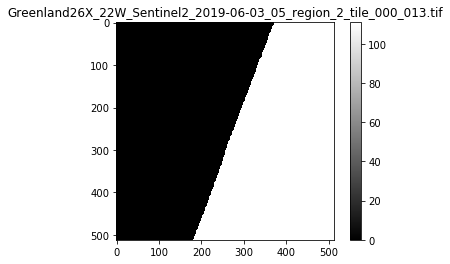

In [34]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def plot_raster(file_path):
    with rasterio.open(file_path) as src:
        # Read the image data
        image = src.read(1) 
        plt.imshow(image, cmap='gray')  
        plt.colorbar()
        plt.title(os.path.basename(file_path))
        #plt.show()
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)

        unique_values = np.unique(image)
        print(f"Unique pixel values in the image: {unique_values}")

image_to_plot = "train_tiles/Greenland26X_22W_Sentinel2_2019-06-03_05_region_2_tile_000_013.tif"
plot_raster(image_to_plot)




Unique pixel values in the image: [0]


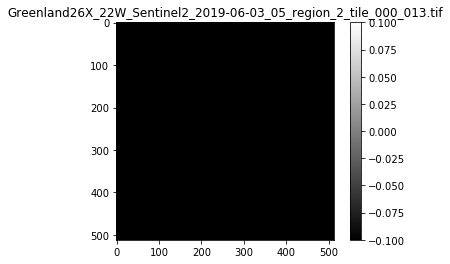

In [33]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def plot_raster(file_path):
    with rasterio.open(file_path) as src:
        # Read the image data
        image = src.read(1)  
        plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
        plt.colorbar()
        plt.title(os.path.basename(file_path))
        #plt.show()
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)

        unique_values = np.unique(image)
        print(f"Unique pixel values in the image: {unique_values}")

image_to_plot = "mask_tiles/Greenland26X_22W_Sentinel2_2019-06-03_05_region_2_tile_000_013.tif"
plot_raster(image_to_plot)

In [53]:


tile_path = "mask_tiles/Greenland26X_22W_Sentinel2_2019-06-03_05_region_2_tile_000_000.tif"

with rasterio.open(tile_path) as tile_src:
    tile_height = tile_src.height
    tile_width = tile_src.width
    num_channels = tile_src.count

print("Dimensions of the saved tile:")
print(f"Height: {tile_height}")
print(f"Width: {tile_width}")
print(f"Number of Channels: {num_channels}")

Dimensions of the saved tile:
Height: 512
Width: 512
Number of Channels: 1


In [ ]:
# attach-tile-train
import os
import rasterio
from rasterio.windows import Window
import glob

TILE_SIZE = 512
OVERLAP = 69

EFFECTIVE_TILE_WIDTH = TILE_SIZE - OVERLAP
EFFECTIVE_TILE_HEIGHT = TILE_SIZE - OVERLAP

def stitch_tiles_to_raster(tiles_directory, prefix, output_directory):
    # Fetch tiles specific to the current prefix
    tiles = sorted(glob.glob(os.path.join(tiles_directory, f"{prefix}_tile_*.tif")))
    
    if not tiles:
        print(f"No tiles found for prefix {prefix}!")
        return

    # Use the first tile to fetch the meta data 
    with rasterio.open(tiles[0]) as first_tile:
        tile_width, tile_height = first_tile.shape

    # Compute the dimensions of the full image
    max_i = max(int(os.path.basename(tile).split('_')[-2]) for tile in tiles)
    max_j = max(int(os.path.basename(tile).split('_')[-1].split('.')[0]) for tile in tiles)

    full_width = max_i * EFFECTIVE_TILE_WIDTH + tile_width
    full_height = max_j * EFFECTIVE_TILE_HEIGHT + tile_height

    # Create an empty array for the full image
    with rasterio.open(tiles[0]) as src:
        meta = src.meta
    meta.update(width=full_width, height=full_height)

    output_path = os.path.join(output_directory, f"{prefix}_stitched.tif")
    
    with rasterio.open(output_path, 'w', **meta) as dst:
        for tile in tiles:
            with rasterio.open(tile) as src:
                i = int(os.path.basename(tile).split('_')[-2])
                j = int(os.path.basename(tile).split('_')[-1].split('.')[0])

                x_offset = i * EFFECTIVE_TILE_WIDTH
                y_offset = j * EFFECTIVE_TILE_HEIGHT

                dst.write(src.read(), window=Window(x_offset, y_offset, tile_width, tile_height))

    print(f"Stitching completed for {prefix}! Result saved in {output_path}")


def stitch_all_in_directory(tiles_directory, output_directory):
    # Extract unique prefixes by parsing tile filenames
    all_tiles = [os.path.basename(f) for f in glob.glob(os.path.join(tiles_directory, "*.tif"))]
    prefixes = set(tile.split('_tile_')[0] for tile in all_tiles)

    for prefix in prefixes:
        stitch_tiles_to_raster(tiles_directory, prefix, output_directory)


tiles_directory = "train_tiles"
output_directory = "stitched_tile_train"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

stitch_all_in_directory(tiles_directory, output_directory)


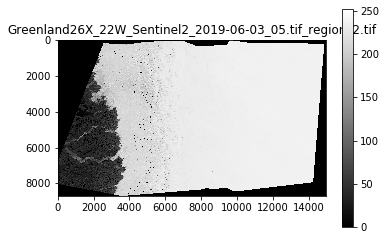

In [22]:
# plot attached
import rasterio
import matplotlib.pyplot as plt

def plot_raster(file_path):
    with rasterio.open(file_path) as src:
        # Read the image data
        image = src.read(1)  # Assuming a single band image, adjust if multi-band
        
        # Plot the image
        plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
        plt.colorbar()
        plt.title(os.path.basename(file_path))
        plt.show()

# Choose one of the stitched images
image_to_plot = os.path.join("train", "Greenland26X_22W_Sentinel2_2019-06-03_05_region_2.tif")
plot_raster(image_to_plot)

In [ ]:
# Convert tiled mask files to png for visualization

# Input and output directories
input_directory = "mask_tiles"
output_directory = "mask_tiles_png"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all .tiff files in the input directory
tiff_files = glob.glob(os.path.join(input_directory, "*.tif"))

# Convert .tiff files to PNG format
for tiff_file in tiff_files:
    # Load the .tiff image using PIL
    tiff_image = Image.open(tiff_file)

    # Construct the output PNG file path
    png_file = os.path.join(output_directory, os.path.splitext(os.path.basename(tiff_file))[0] + ".png")

    # Save the image as PNG without changing dimensions or pixel values
    tiff_image.save(png_file)

    print(f"Converted {os.path.basename(tiff_file)} to PNG")

print("Conversion completed.")


In [61]:
# Convert tiled train to png format for visualization


input_directory = "train_tiles"
output_directory = "train_tiles_png"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all .tiff files in the input directory
tiff_files = glob.glob(os.path.join(input_directory, "*.tif"))

# Convert .tiff files to PNG format
for tiff_file in tiff_files:
    # Load the .tiff image using PIL
    tiff_image = Image.open(tiff_file)

    # Construct the output PNG file path
    png_file = os.path.join(output_directory, os.path.splitext(os.path.basename(tiff_file))[0] + ".png")

    # Save the image as PNG without changing dimensions or pixel values
    tiff_image.save(png_file)

   # print(f"Converted {os.path.basename(tiff_file)} to PNG")

print("Conversion completed.")

Conversion completed.


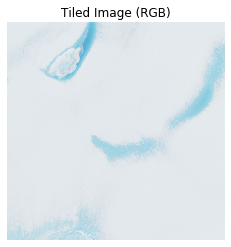

In [81]:


# Path to a single tiled mask image
tiled_image_path = "train_tiles/Greenland26X_22W_Sentinel2_2019-07-31_25_region_2_tile_024_011.tif"

# Open the image using rasterio
with rasterio.open(tiled_image_path) as src:
    image_data = src.read()  # Reading all channels

# Transpose the image data to (channels, height, width) format
image_data = image_data.transpose(1, 2, 0)

# Plot the image using Matplotlib
plt.imshow(image_data)
plt.title("Tiled Image (RGB)")
plt.axis('off')  # Turn off axis
plt.show()



/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


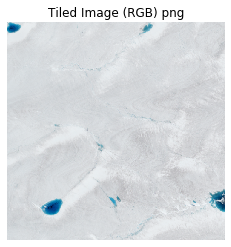

In [88]:


# Path to a single tiled mask image
tiled_image_path = "train_tiles_png/Greenland26X_22W_Sentinel2_2019-06-03_05_region_2_tile_010_017.png"

# Open the image using rasterio
with rasterio.open(tiled_image_path) as src:
    image_data = src.read()  # Reading all channels

# Transpose the image data to (channels, height, width) format
image_data = image_data.transpose(1, 2, 0)

# Plot the image using Matplotlib
plt.imshow(image_data)
plt.title("Tiled Image (RGB) png")
plt.axis('off')  # Turn off axis
plt.show()

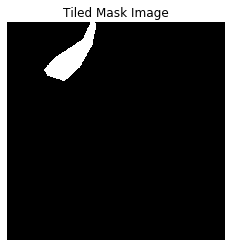

In [26]:
import os
import rasterio
import matplotlib.pyplot as plt

# Path to a single tiled mask image
tiled_mask_path = "mask_tiles/Greenland26X_22W_Sentinel2_2019-07-31_25_region_2_tile_024_011.tif"

# Open the mask image using rasterio
with rasterio.open(tiled_mask_path) as src:
    mask_image = src.read(1)  # Assuming mask images are single-channel

# Plot the mask image using Matplotlib
plt.imshow(mask_image, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
plt.title("Tiled Mask Image")
plt.axis('off')  # Turn off axis
plt.show()


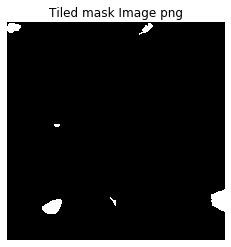

In [91]:
import os
import rasterio
import matplotlib.pyplot as plt

# Path to a single tiled mask image
tiled_mask_path = "mask_tiles_png/Greenland26X_22W_Sentinel2_2019-06-03_05_region_2_tile_010_017.png"

# Open the mask image using rasterio
with rasterio.open(tiled_mask_path) as src:
    mask_image = src.read(1)  # Assuming mask images are single-channel

# Plot the mask image using Matplotlib
plt.imshow(mask_image, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
plt.title("Tiled mask Image png")
plt.axis('off')  # Turn off axis
plt.show()


**End of additional exploratory data analysis**

**Part 4: Provide a balanced data set to be used in submission_1 and submission_2:**

The results of the below cells are available on Google Drive with the names "filtered_2k_lake_2k_none_lake_train_tiles" and "filtered_2k_lake_2k_none_lake_mask_tiles" for downloading. By downloading them, you can skip this part.

This subset consists of 2,000 images of their masks labeled as "lake" (1) and a random selection of 2,000 images of their masks labeled as "no lake" (0).

Make a folder containing images with their mask labeled with 0 and 1 (lake)

In [ ]:
# find how many mask images contain lake


mask_directory = "mask_tiles"

# List all .tif mask files in the directory
mask_files = glob.glob(os.path.join(mask_directory, "*.tif"))

# Initialize counters
mask_images_with_ones = 0

# Iterate through each mask file
for mask_file in mask_files:
    with rasterio.open(mask_file) as src:
        mask_image = src.read(1) 

        # Check if the mask image contains pixel values of 1
        if 1 in mask_image:
            mask_images_with_ones += 1
            print(f"Mask image '{os.path.basename(mask_file)}' contains pixel values of 1.")

print(f"Total mask images with pixel value of 1: {mask_images_with_ones}")



Total mask images with the pixel value of 1: 2048

Copy them into a new folder

In [96]:
import os
import rasterio
from shutil import copyfile

# Paths to the mask_tiles and train_tiles folders
mask_tiles_folder = "mask_tiles"
train_tiles_folder = "train_tiles"

# Paths to the new folders for mask images and corresponding train images
filtered_mask_folder = "filtered_mask_tiles"
filtered_train_folder = "filtered_train_tiles"

# Ensure output directories exist
for dir_path in [filtered_mask_folder, filtered_train_folder]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Find mask tiles containing white pixels and save them in the new folder
mask_files = os.listdir(mask_tiles_folder)
for mask_filename in mask_files:
    mask_path = os.path.join(mask_tiles_folder, mask_filename)
    with rasterio.open(mask_path) as src:
        mask_image = src.read(1)
        if 1 in mask_image:  # Check if mask contains white pixels (value 1)
            filtered_mask_path = os.path.join(filtered_mask_folder, mask_filename)
            copyfile(mask_path, filtered_mask_path)
            # Find corresponding train image and save it in the new folder
            #train_filename = mask_filename.replace("mask_", "")
            train_path = os.path.join(train_tiles_folder, mask_filename)
            filtered_train_path = os.path.join(filtered_train_folder, mask_filename)
            copyfile(train_path, filtered_train_path)

print("Filtered mask and train images saved successfully!")


Filtered mask and train images saved successfully!


In [97]:
# The number of tiled images contains lake

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'filtered_train_tiles'
print(count_files_in_directory(directory_path))


2048


In [98]:
# The number of tiled masks contains lake

def count_files_in_directory(directory_path):
    list_of_files = os.listdir(directory_path)
    number_of_files = len(list_of_files)
    return number_of_files

directory_path = 'filtered_mask_tiles'
print(count_files_in_directory(directory_path))

2048


In [101]:
# Convert to png format for visualization

# Path to the directory containing TIFF mask files
tiff_mask_folder = "filtered_mask_tiles"

# Path to the directory where PNG mask files will be saved
png_mask_folder = "filtered_mask_tiles_png"

# Ensure output directory exists
if not os.path.exists(png_mask_folder):
    os.makedirs(png_mask_folder)

# Loop through TIFF mask files and convert them to PNG
tiff_mask_files = [f for f in os.listdir(tiff_mask_folder) if f.endswith(".tif")]
for tiff_mask_filename in tiff_mask_files:
    tiff_mask_path = os.path.join(tiff_mask_folder, tiff_mask_filename)
    png_mask_filename = os.path.splitext(tiff_mask_filename)[0] + ".png"
    png_mask_path = os.path.join(png_mask_folder, png_mask_filename)
    
    # Open the TIFF image using PIL
    tiff_image = Image.open(tiff_mask_path)
    
    # Convert and save as PNG
    tiff_image.save(png_mask_path, format="PNG")

print("Conversion from TIFF to PNG completed successfully!")


Conversion from TIFF to PNG completed successfully!


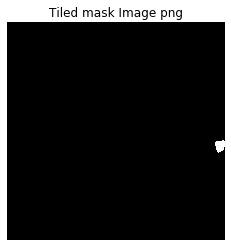

In [103]:

# Path to a single tiled mask image
tiled_mask_path = "filtered_mask_tiles_png/Greenland26X_22W_Sentinel2_2019-06-03_05region_2_tile_008_016.png"

# Open the mask image using rasterio
with rasterio.open(tiled_mask_path) as src:
    mask_image = src.read(1)
plt.imshow(mask_image, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
plt.title("Tiled mask Image png")
plt.axis('off')  # Turn off axis
plt.show()


In [ ]:
# Mask images contain 0 and 1, so convert them to high_contrast_masks for visualization
import os
import numpy as np
import rasterio
from PIL import Image
import glob

# Input and output directories
input_directory = "filtered_mask_tiles"
output_directory = "filtered_mask_tiles_png_255"

# Ensure output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop through all mask image files in the input directory
mask_files = glob.glob(os.path.join(input_directory, "*.tif"))
for mask_file in mask_files:
    # Open the mask image using rasterio
    with rasterio.open(mask_file) as src:
        mask_image = src.read(1) 

    # Convert mask image to 8-bit PNG format
    png_mask_image = (mask_image * 255).astype(np.uint8)

    output_png_path = os.path.join(output_directory, os.path.basename(mask_file).replace(".tif", ".png"))

    Image.fromarray(png_mask_image).save(output_png_path)

    print(f"Saved PNG image to {output_png_path}")


In [ ]:
# Mask images contain 0 and 1, so convert them to high_contrast_masks for visualization
import os
import numpy as np
import rasterio
from PIL import Image
import glob

# Input and output directories
input_directory = "mask_tiles"
output_directory = "mask_tiles_png_255"

# Ensure output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop through all mask image files in the input directory
mask_files = glob.glob(os.path.join(input_directory, "*.tif"))
for mask_file in mask_files:
    # Open the mask image using rasterio
    with rasterio.open(mask_file) as src:
        mask_image = src.read(1)  

    # Convert mask image to 8-bit PNG format
    png_mask_image = (mask_image * 255).astype(np.uint8)

    output_png_path = os.path.join(output_directory, os.path.basename(mask_file).replace(".tif", ".png"))
    Image.fromarray(png_mask_image).save(output_png_path)

    print(f"Saved PNG image to {output_png_path}")

In [100]:
from PIL import Image
import os
import glob

# Input and output directories
input_directory = "filtered_train_tiles"
output_directory = "filtered_train_tiles_png"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all .tiff files in the input directory
tiff_files = glob.glob(os.path.join(input_directory, "*.tif"))

# Convert .tiff files to PNG format
for tiff_file in tiff_files:
    # Load the .tiff image using PIL
    tiff_image = Image.open(tiff_file)

    png_file = os.path.join(output_directory, os.path.splitext(os.path.basename(tiff_file))[0] + ".png")

    tiff_image.save(png_file)

   # print(f"Converted {os.path.basename(tiff_file)} to PNG")

print("Conversion completed.")

Conversion completed.


In [ ]:
import os
import shutil
import random
# Check if the selected_image_folder exists, if not, create it
if not os.path.exists('filtered_2k_lake_2k_none_lake_mask_tiles'):
    os.makedirs('filtered_2k_lake_2k_none_lake_mask_tiles')

# Check if the selected_mask_folder exists, if not, create it
if not os.path.exists('filtered_2k_lake_2k_none_lake_train_tiles'):
    os.makedirs('filtered_2k_lake_2k_none_lake_train_tiles')
    

In [ ]:
    
# Define source and destination folders
source_folder = 'filtered_train_tiles'
destination_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'

# Check if the destination folder exists, if not, create it
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate over all files in the source folder and copy them to the destination folder
for file_name in os.listdir(source_folder):
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)

    # Check if it's a file (this will exclude subdirectories)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)

print("Copying completed!")

In [ ]:
# Define source and destination folders
source_folder = 'filtered_mask_tiles'
destination_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Check if the destination folder exists, if not, create it
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate over all files in the source folder and copy them to the destination folder
for file_name in os.listdir(source_folder):
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)

    # Check if it's a file (this will exclude subdirectories)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)

print("Copying completed!")

In [ ]:
import os
import shutil
import random

# Source folders
image_folder = 'train_tiles'
mask_folder = 'mask_tiles'

# Destination folders
selected_image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'
selected_mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Check if the destination folders exist, if not, create them
if not os.path.exists(selected_image_folder):
    os.makedirs(selected_image_folder)

if not os.path.exists(selected_mask_folder):
    os.makedirs(selected_mask_folder)

# Get all images from the source folder
all_images = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Get all images from the destination folder
existing_images = set(f for f in os.listdir(selected_image_folder) if os.path.isfile(os.path.join(selected_image_folder, f)))

# Filter out the images that are already in the destination folder
images_to_select_from = [image for image in all_images if image not in existing_images]

# Check if we have enough images to copy
if len(images_to_select_from) < 2000:
    print(f"Only {len(images_to_select_from)} non-duplicate images available. Copying them all.")
    selected_images = images_to_select_from
else:
    # Randomly select 2000 images from the filtered list
    selected_images = random.sample(images_to_select_from, 2000)

# Copy selected images and their corresponding masks to new folders
for image in selected_images:
    # Construct the source and destination paths
    image_src = os.path.join(image_folder, image)
    image_dst = os.path.join(selected_image_folder, image)

    # Assuming mask files have the same name as image files but located in a different folder
    mask_src = os.path.join(mask_folder, image)
    mask_dst = os.path.join(selected_mask_folder, image)

    # Copy the files
    shutil.copy(image_src, image_dst)
    shutil.copy(mask_src, mask_dst)

print("Copying completed!")


In [35]:

def count_files_in_directory(directory_path):
    return sum([1 for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
# Destination folders
selected_image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'
selected_mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Counting number of files in destination folders
num_images_in_selected_folder = count_files_in_directory(selected_image_folder)
num_masks_in_selected_folder = count_files_in_directory(selected_mask_folder)

print(f"Number of images in the destination image folder: {num_images_in_selected_folder}")
print(f"Number of masks in the destination mask folder: {num_masks_in_selected_folder}")

Number of images in the destination image folder: 4048
Number of masks in the destination mask folder: 4048


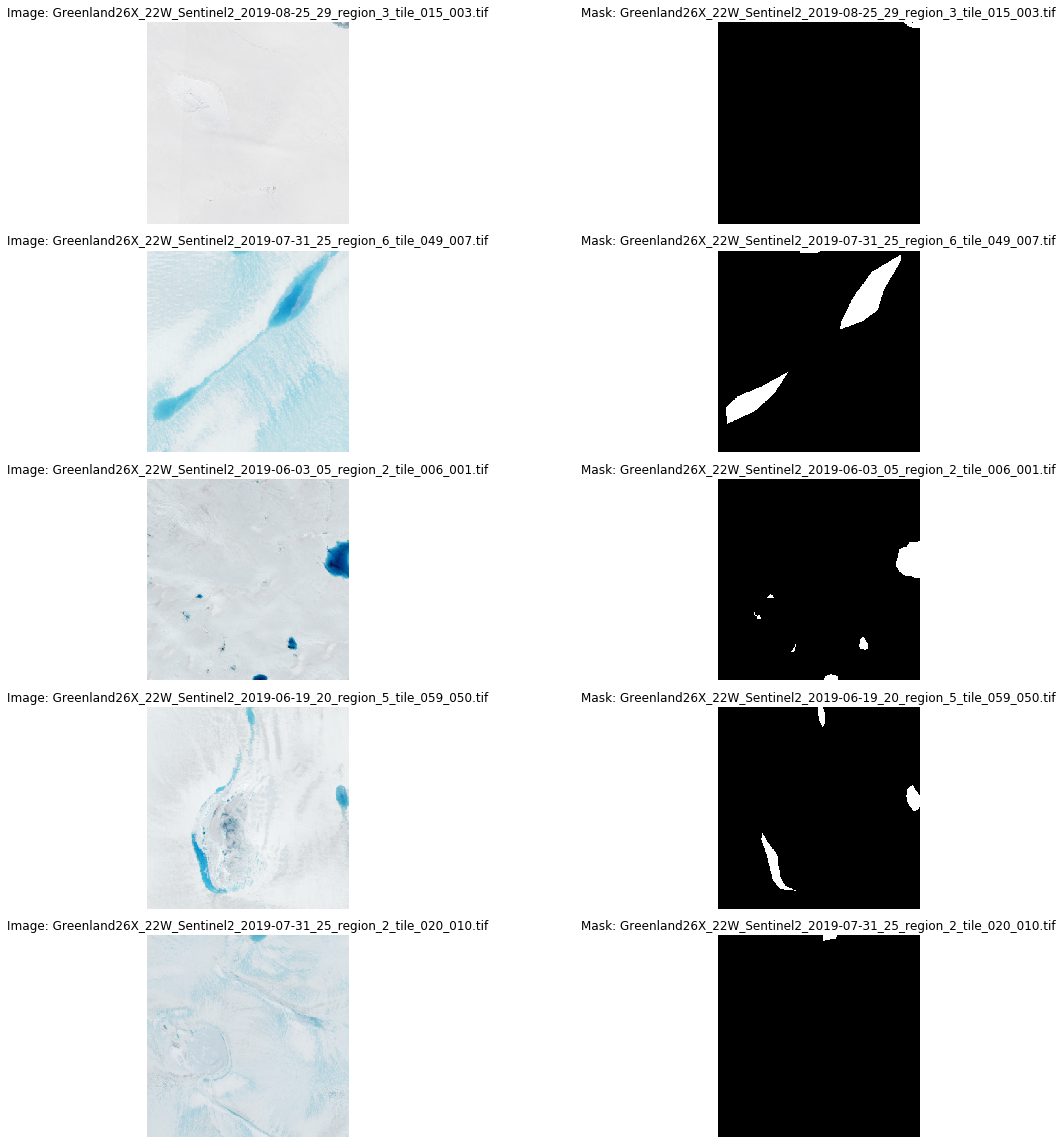

In [40]:

import random
from tifffile import imread  

# Define the image and mask directories
image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'
mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Get all image filenames
all_images = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Randomly select 5 images
selected_images = random.sample(all_images, 5)
fig, axes = plt.subplots(5, 2, figsize=(16, 16))

for i, image_name in enumerate(selected_images):
    # Read image and its corresponding mask
    image_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(mask_folder, image_name)
    
    image = imread(image_path)
    mask = imread(mask_path)
    
    # Plot image and mask
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {image_name}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask: {image_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()